In [ ]:
# Multiclass classification

# nonlinear classifier - the RandomForestClassifier. It requires little hyperparameter tuning.

# No need for imputing the missing data --> data description.

# Problem: You can't see every tree.. predict the health of the tree.

In [1]:
# Import third-party packages.
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import seaborn as sns
from shapely.geometry import Point
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

%matplotlib inline

# Change display settings for dataframes.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in data on trees.
#df_1995 = pd.read_csv('./data/nyc_trees/nyc_tree_census_1995.csv.gz', compression='gzip')
#df_2005 = pd.read_csv('./data/nyc_trees/nyc_tree_census_2005.csv.gz', compression='gzip')
df_2015 = pd.read_csv('./data/nyc_trees/nyc_tree_census_2015.csv.gz', compression='gzip')
#df_1995.drop('Unnamed: 0', axis=1, inplace=True)
#df_2005.drop('Unnamed: 0', axis=1, inplace=True)
df_2015.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
# Read in geographic data on New York City.
nyc = gpd.read_file('./data/nyc/nyc_geo.shp')

In [3]:
test = df_2015.copy()

In [4]:
test_geo = gpd.GeoDataFrame(test, geometry=[Point(coordinates) for coordinates in zip(test['longitude'], test['latitude'])])

In [5]:
# Create circles with a 20m radius around each tree location. But since the radius of a tree might just touch another, the
# maximum distance between such trees should be 20m and thus a radius of 10m each.
test_geo.crs = {'init': 'epsg:4326', 'no_defs': True}
test_geo = test_geo.to_crs(epsg=3857)
test_geo.crs = {'init': 'epsg:3857', 'no_defs': True}
buffers = test_geo.buffer(10)
test_geo = test_geo.to_crs(epsg=4326)
test_geo.crs = {'init': 'epsg:4326', 'no_defs': True}
buffers = buffers.to_crs(epsg=4326)
buffers.crs = {'init': 'epsg:4326', 'no_defs': True}
buffers_gdf = gpd.GeoDataFrame(buffers, geometry=buffers)
buffers_gdf.rename(columns={0:'circles'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [30]:
res = gpd.sjoin(test_geo, buffers_gdf, how='right')

In [8]:
res.drop('index_right', axis=1, inplace=True)

In [31]:
n_neighbors = res.groupby('tree_id').count()
test_new = pd.merge(test, n_neighbors[['circles']], on='tree_id', right_index=True)

In [32]:
n_neighbors['circles'].value_counts()

1     451367
2     168522
3      54210
4       5531
5       2210
6        840
7        394
8        235
9        145
10        96
12        52
46        45
29        28
11        25
15        20
17        20
18        18
13        16
16         5
19         4
20         2
14         1
30         1
47         1
Name: circles, dtype: int64

In [33]:
res_2 = pd.merge(res, n_neighbors['circles'], left_on='tree_id', right_on='tree_id')

In [34]:
res_2['circs_lat'] = res_2.geometry.centroid.y.values

In [35]:
res_2['circs_long'] = res_2.geometry.centroid.x.values

In [38]:
from geopy.distance import geodesic

res_2['distance_geopy'] = [geodesic((res_2['latitude'].loc[i], res_2['longitude'].loc[i]), (res_2['circs_lat'].loc[i], res_2['circs_long'].loc[i])).meters for i in res_2.index]

In [37]:
res_2.sort_values('tree_id')

,index_left,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl,circles_x,geometry,circles_y,circs_lat,circs_long,distance_geopy
768219,519996,3,501451,05/19/2015,24,0,OnCurb,Alive,Good,Quercus palustris,pin oak,1or2,None,Damage,NYC Parks Staff,None,No,No,No,No,No,No,No,No,No,766 MANIDA STREET,10474,Bronx,202,2,Bronx,17,84,32,BX27,Hunts Point,2009300,New York,40.816467,-73.889175,1014925.946,236757.4196,17.0,93.0,2006497.0,2.027630e+09,"POLYGON ((-73.88909 40.81647, -73.88909 40.816...","POLYGON ((-73.88909 40.81647, -73.88909 40.816...",1,40.816467,-73.889175,2.8959194472231252e-09 km
767708,519721,4,501451,05/19/2015,20,0,OnCurb,Alive,Good,Quercus palustris,pin oak,1or2,None,NoDamage,NYC Parks Staff,None,No,No,No,No,No,No,No,No,No,1241 LAFAYETTE AVENUE,10474,Bronx,202,2,Bronx,17,84,32,BX27,Hunts Point,2009300,New York,40.816434,-73.889595,1014809.582,236745.2369,17.0,93.0,2006002.0,2.027400e+09,"POLYGON ((-73.88951 40.81643, -73.88951 40.816...","POLYGON ((-73.88951 40.81643, -73.88951 40.816...",1,40.816434,-73.889595,2.9001607009981608e-09 km
113884,69625,7,501911,05/19/2015,3,0,OnCurb,Alive,Poor,Betula pendula,silver birch,3or4,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,1242 SPOFFORD AVENUE,10474,Bronx,202,2,Bronx,17,84,34,BX27,Hunts Point,2009300,New York,40.814092,-73.889123,1014941.504,235892.2330,17.0,93.0,2006623.0,2.027650e+09,"POLYGON ((-73.88898 40.81410, -73.88898 40.814...","POLYGON ((-73.88898 40.81410, -73.88898 40.814...",2,40.814100,-73.889070,0.004571661885498203 km
113883,69625,7,501911,05/19/2015,3,0,OnCurb,Alive,Poor,Betula pendula,silver birch,3or4,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,1242 SPOFFORD AVENUE,10474,Bronx,202,2,Bronx,17,84,34,BX27,Hunts Point,2009300,New York,40.814092,-73.889123,1014941.504,235892.2330,17.0,93.0,2006623.0,2.027650e+09,"POLYGON ((-73.88903 40.81409, -73.88903 40.814...","POLYGON ((-73.88903 40.81409, -73.88903 40.814...",2,40.814092,-73.889123,2.8994547945733195e-09 km
42686,69626,8,501911,05/19/2015,3,0,OnCurb,Alive,Poor,Betula pendula,silver birch,3or4,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,1242 SPOFFORD AVENUE,10474,Bronx,202,2,Bronx,17,84,34,BX27,Hunts Point,2009300,New York,40.814100,-73.889070,1014956.216,235895.1546,17.0,93.0,2006623.0,2.027650e+09,"POLYGON ((-73.88898 40.81410, -73.88898 40.814...","POLYGON ((-73.88898 40.81410, -73.88898 40.814...",3,40.814100,-73.889070,2.8994547959122246e-09 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739935,497037,722690,999999,10/05/2016,3,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,NoDamage,NYC Parks Staff,None,No,No,No,No,No,No,No,No,No,1252 EAST 105 STREET,11236,Brooklyn,318,3,Brooklyn,46,58,19,BK50,Canarsie,3101400,New York,40.641570,-73.888160,1015288.355,173037.2704,46.0,1014.0,3233193.0,3.082690e+09,"POLYGON ((-73.88807 40.64157, -73.88807 40.641...","POLYGON ((-73.88807 40.64157, -73.88807 40.641...",1,40.641570,-73.888160,2.89447736240025e-09 km
741702,498351,722691,999999,10/05/2016,2,0,OnCurb,Alive,Good,Acer rubrum,red maple,None,None,NoDamage,NYC Parks Staff,None,No,No,No,No,No,No,No,No,No,1246 EAST 105 STREET,11236,Brooklyn,318,3,Brooklyn,46,58,19,BK50,Canarsie,3101400,New York,40.641690,-73.888289,1015252.518,173081.2520,46.0,1014.0,3233191.0,3.082690e+09,"POLYGON ((-73.88820 40.64169, -73.88820 40.641...","POLYGON ((-73.88820 40.64169, -73.88820 40.641...",1,40.641690,-73.888289,2.8962442459076737e-09 km


In [40]:
# Number of neighboring trees with a 20m radius per tree on average.
res_2[res_2['circles_y'] > 1]['circles_y'].mean()

2.811806970879823

In [41]:
# Average distance of a street tree to another street tree in New York.
res_2[res_2['circles_y'] > 1]['distance_geopy'].mean()

3.2996497791571295

In [8]:
n_neighbors = res.groupby('tree_id').count()
test_new = pd.merge(test, n_neighbors[['circles']], on='tree_id', right_index=True)

In [9]:
# Encode the feature on the number of neighboring trees.
test_new.loc[test_new['n_neighbors'] == 1, 'n_neighbors'] = 0.1
test_new.loc[((test_new['n_neighbors'] >= 2) & (test_new['n_neighbors'] <= 3)), 'n_neighbors'] = 0.2
test_new.loc[test_new['n_neighbors'] >= 4, 'n_neighbors'] = 0.3
test_new.loc[test_new['n_neighbors'] == 0.1, 'n_neighbors'] = "no neighbor"
test_new.loc[test_new['n_neighbors'] == 0.2, 'n_neighbors'] = "two or three neighbors"
test_new.loc[test_new['n_neighbors'] == 0.3, 'n_neighbors'] = "more than three neighbors"

In [13]:
test_new.tree_dbh.corr(test_new.health)

0.07423817812763712

In [ ]:
# Nur für einen Eintrag
neighbors = []
for ind, i in enumerate(test_geo.index):
    print(ind)
    if test_geo['geometry'].loc[0].intersects(buffers.loc[i]):
        neighbors.append(i)

In [ ]:
# Circa mehr als 2 Tage Rechenaufwand..
test_geo = test_geo.to_crs(epsg=3857)
test_geo.crs = {'init': 'epsg:3857', 'no_defs': True}

xs_all = test_geo['geometry'].x
ys_all = test_geo['geometry'].y
pot_neighbors = np.array(list(zip(xs_all, ys_all)))

def n_neighbors(point, size=3, distance=10.0, potential_neighbors=pot_neighbors):
    point = point.reshape(-1, 2)
    bin_trie = cKDTree(point)
    remaining_points = np.delete(potential_neighbors, np.where(potential_neighbors == point), axis=0).reshape(-1, 2)
    dist, ids = bin_trie.query(remaining_points, k=size, distance_upper_bound=distance, n_jobs=-1)
    count_neighbors = len(dist[dist != np.inf])
    
    return count_neighbors

inp = np.array(list(zip(test_geo['geometry'].x.values, test_geo['geometry'].y.values)))

test_geo['n_neighbors'] = [n_neighbors(i) for i in inp]

In [ ]:
nyc = nyc.to_crs(epsg=4326)
nyc.crs = {'init': 'epsg:4326', 'no_defs': True}
circles = buffers.unary_union
a = nyc['geometry'].intersection(circles)

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
sns.set(style='whitegrid')
sns.mpl.rc('figure')
fig, ax = plt.subplots()
a.plot(ax=ax)

In [ ]:
tree_radi = nyc.intersection(trees_geo_circs)
tree_radi.plot(ax=ax)

In [10]:
df_sel = test_new[['tree_id',
               'steward',
               'guards',
               'root_stone',
               'root_grate',
               'root_other',
               'trunk_wire',
               'trnk_light',
               'trnk_other',
               'brch_light',
               'brch_shoe',
               'brch_other',
               'circles',
               'health']]

# Replace NaN values in features with entries signalling this tree is either dead or a stump.
df_sel['steward'].fillna('Dead|Stump', inplace=True)
df_sel['guards'].fillna('Dead|Stump', inplace=True)

# In 'steward', replace spectrum of answers to yes (= alive) or no (= dead/stump).
df_sel['steward'].replace(['1or2', '3or4', '4orMore', 'None'], 'Alive', inplace=True)

# Replace NaN values in the target with entries signalling this tree is either dead or a stump.
df_sel['health'].fillna('Dead|Stump', inplace=True)

#df_sel['health'].replace(['Poor', 'Fair'], 'Poor|Fair', inplace=True)

# One-hot encoding the categorical features and the target.
df_sel_enc = pd.get_dummies(df_sel)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


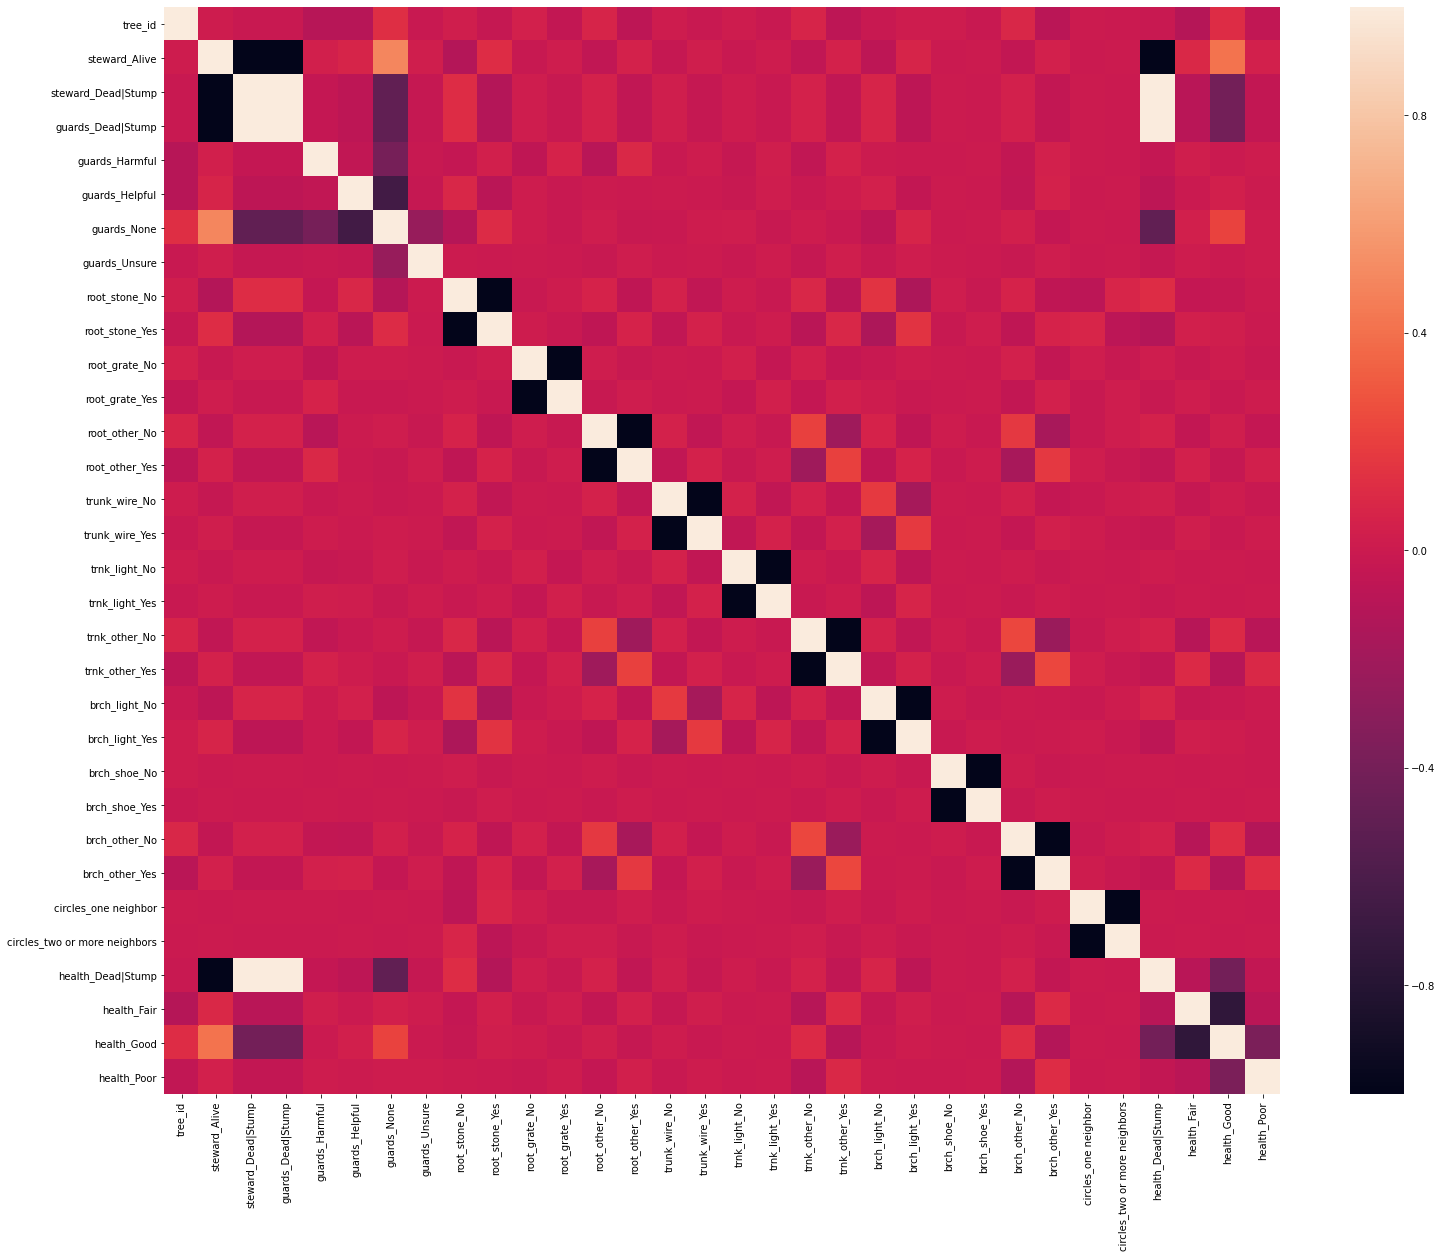

In [11]:
corrmat = df_sel_enc.corr()
plt.subplots(figsize=(25,20))
sns.heatmap(corrmat, annot=False)
plt.show()

In [83]:
x = df_sel_enc[list(df_sel_enc.columns)[1:28]]
y = df_sel_enc[list(df_sel_enc.columns)[28:]]

# Split into train, test, and validation datasets, with stratification as some labels were not predicted in previous runs.
# x_train_vali, x_test, y_train_vali, y_test = train_test_split(x, y, random_state=0)
# x_train, x_vali, y_train, y_vali = train_test_split(x_train_vali, y_train_vali, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=None, stratify=y)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000193EF9A2BE0>,
      dtype=object)

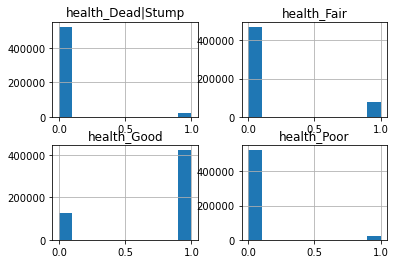

In [75]:
y_train.hist()

In [92]:
target_first_class = len(y.loc[y['health_Dead|Stump'] == 0]) / len(y)
target_second_class = len(y.loc[y['health_Fair'] == 0]) / len(y)
target_third_class = len(y.loc[y['health_Good'] == 0]) / len(y)
target_fourth_class = len(y.loc[y['health_Poor'] == 0]) / len(y)


class_weight_orig = [{0:target_first_class, 1:1-target_first_class},
                     {0:target_second_class, 1:1-target_second_class},
                     {0:target_third_class, 1:1-target_third_class},
                     {0:target_fourth_class, 1:1-target_fourth_class}]

class_weight_manip = [{0:target_first_class/2, 1:1-target_first_class/2},
                      {0:target_second_class/2, 1:1-target_second_class/2},
                      {0:target_third_class/2, 1:1-target_third_class/2},
                      {0:target_fourth_class/2, 1:1-target_fourth_class/2}]

In [20]:
from imblearn.under_sampling import RandomUnderSampler

rs = RandomUnderSampler(sampling_strategy='majority', random_state=None)
x_train_rs_fair, y_train_rs_fair = rs.fit_sample(x_train, y_train['health_Fair'])
x_train_rs_poor, y_train_rs_poor = rs.fit_sample(x_train, y_train['health_Poor'])


health_fair_rs = pd.concat([x_train_rs_fair, y_train_rs_fair], axis=1)
health_poor_rs = pd.concat([x_train_rs_poor, y_train_rs_poor], axis=1)
health_fair_rs = health_fair_rs[health_fair_rs.health_Fair == 1]
health_poor_rs = health_poor_rs[health_poor_rs.health_Poor == 1]

df_sel_enc_rs = pd.concat([df_sel_enc, health_fair_rs, health_poor_rs], ignore_index=True)
df_sel_enc_rs.fillna(0, inplace=True)
df_sel_enc_rs[df_sel_enc_rs.columns[-4:]] = df_sel_enc_rs[df_sel_enc_rs.columns[-4:]].astype(int)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001940D991518>,
      dtype=object)

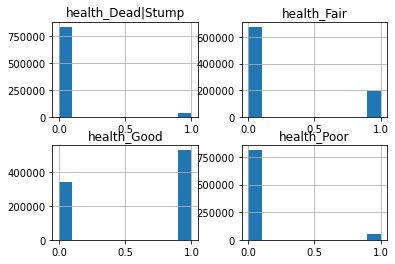

In [21]:
df_sel_enc_rs[['health_Dead|Stump', 'health_Fair', 'health_Good', 'health_Poor']].hist()

In [84]:
from imblearn.over_sampling import SMOTE

smote_sampler = SMOTE(sampling_strategy='not majority', random_state=None, n_jobs=-1)
x_train_smo_fair, y_train_smo_fair = sm_fairpoor.fit_sample(x_train, y_train['health_Fair'])
x_train_smo_poor, y_train_smo_poor = sm_fairpoor.fit_sample(x_train, y_train['health_Poor'])
x_train_smo_good, y_train_smo_good = smote_sampler.fit_sample(x_train, y_train['health_Good'])
x_train_smo_deadstump, y_train_smo_deadstump = smote_sampler.fit_sample(x_train, y_train['health_Dead|Stump'])

In [85]:
health_fair = pd.concat([x_train_smo_fair, y_train_smo_fair], axis=1)
health_poor = pd.concat([x_train_smo_poor, y_train_smo_poor], axis=1)
health_fair = health_fair[health_fair.health_Fair != 0]
health_poor = health_poor[health_poor.health_Poor != 0]
health_good = pd.concat([x_train_smo_good, y_train_smo_good], axis=1)
health_good = health_good[health_good.health_Good != 0]
health_deadstump = pd.concat([x_train_smo_deadstump, y_train_smo_deadstump], axis=1)
health_deadstump = health_deadstump[health_deadstump['health_Dead|Stump'] != 0]
df_sel_enc_smo = pd.concat([health_fair, health_poor, health_good, health_deadstump], ignore_index=True)
#df_sel_enc_smo = pd.concat([df_sel_enc, health_fair, health_poor], ignore_index=True)
df_sel_enc_smo.fillna(0, inplace=True)
df_sel_enc_smo[df_sel_enc_smo.columns[-4:]] = df_sel_enc_smo[df_sel_enc_smo.columns[-4:]].astype(int)

In [283]:
df_sel_enc_smo.drop_duplicates(inplace=True)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019408E05400>,
      dtype=object)

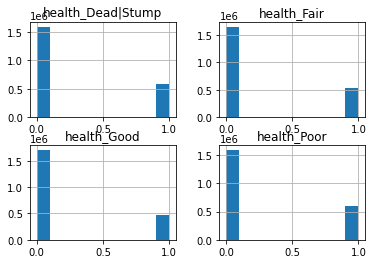

In [86]:
df_sel_enc_smo[['health_Dead|Stump', 'health_Fair', 'health_Good', 'health_Poor']].hist()

In [87]:
x_new = df_sel_enc_smo[list(df_sel_enc_smo.columns)[1:27]]
y_new = df_sel_enc_smo[list(df_sel_enc_smo.columns)[27:]]

# Split into train, test, and validation datasets, with stratification as some labels were not predicted in previous runs.
# x_train_vali, x_test, y_train_vali, y_test = train_test_split(x, y, random_state=0)
# x_train, x_vali, y_train, y_vali = train_test_split(x_train_vali, y_train_vali, random_state=0)

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, test_size=0.2, random_state=None, stratify=y_new)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019418779DA0>,
      dtype=object)

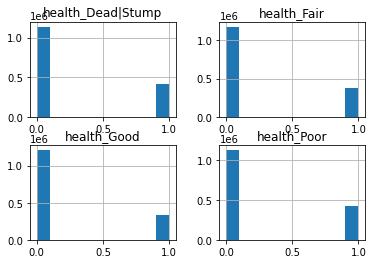

In [80]:
y_train_new.hist()

In [93]:
rdf_clf = RandomForestClassifier(class_weight=class_weight_manip)
rdf_clf.fit(x_train_new, y_train_new)
y_pred_new = rdf_clf.predict(x_test_new)
print(accuracy_score(y_test_new, y_pred_new))

0.5030191272477379


In [91]:
print(classification_report(y_test_new, y_pred_new, target_names=y_new.columns))
print("F1-score of positive classes:", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average=None))
print("F1-score (micro):", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average='micro'))
print("F1-score (macro):", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average='macro'))
print("F1-score (weighted):", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average='weighted'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

      health_Fair       0.82      0.00      0.01    105711
      health_Poor       0.37      1.00      0.54    118255
      health_Good       0.43      0.00      0.01     95193
health_Dead|Stump       1.00      1.00      1.00    117391

        micro avg       0.54      0.54      0.54    436550
        macro avg       0.66      0.50      0.39    436550
     weighted avg       0.66      0.54      0.42    436550
      samples avg       0.54      0.54      0.54    436550

F1-score of positive classes: [0.00670768 0.5421336 ]
F1-score (micro): 0.43728530895217854
F1-score (macro): 0.274420639819845
F1-score (weighted): 0.2894148415328575


In [36]:
rdf_clf = RandomForestClassifier(class_weight=class_weight_manip)
rdf_clf.fit(x_train, y_train)
y_pred = rdf_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.12202320017315309


In [15]:
# "if the macromedia result is significantly lower than the micromedia one, it means your smaller labels
# are poorly classified, whereas your larger ones are probably correctly classified."
print(classification_report(y_test, y_pred, target_names=y.columns))
print("F1-score of positive classes:", f1_score(y_test, y_pred, labels=np.unique(y_pred), average=None))
print("F1-score (micro):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='micro'))
print("F1-score (macro):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='macro'))
print("F1-score (weighted):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='weighted'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Fair       0.35      0.00      0.00     48252
      health_Good       0.81      1.00      0.90    264425
      health_Poor       0.18      0.00      0.00     13409

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.58      0.50      0.47    341894
     weighted avg       0.73      0.82      0.74    341894
      samples avg       0.82      0.82      0.82    341894

F1-score of positive classes: [1.         0.00119993]
F1-score (micro): 0.39616269761857115
F1-score (macro): 0.500599966898378
F1-score (weighted): 0.2476724821348903


In [226]:
feature_imp = pd.Series(rdf_clf.feature_importances_, index=x.columns).sort_values(ascending=False)
print(feature_imp)

guards_Dead|Stump                0.367684
steward_Dead|Stump               0.339992
guards_None                      0.161721
brch_other_No                    0.022178
guards_Helpful                   0.018858
brch_other_Yes                   0.018617
trnk_other_Yes                   0.014066
trnk_other_No                    0.013431
guards_Harmful                   0.005660
root_stone_Yes                   0.005515
root_stone_No                    0.004968
root_other_Yes                   0.003644
trunk_wire_Yes                   0.003497
brch_light_No                    0.002663
brch_light_Yes                   0.002562
root_grate_Yes                   0.002333
guards_Unsure                    0.002297
root_other_No                    0.002003
trnk_light_Yes                   0.001943
circles_two or more neighbors    0.001723
circles_one neighbor             0.001105
trunk_wire_No                    0.001088
brch_shoe_Yes                    0.001027
root_grate_No                    0

In [110]:
# Training & pruning with model-based feature selection.
rdf_clf_sm = SelectFromModel(RandomForestClassifier(random_state=0), threshold='median')
rdf_clf_sm.fit(x_train, y_train)
x_train_fs = rdf_clf_sm.transform(x_train)
x_test_fs = rdf_clf_sm.transform(x_test)
rdf_clf_n = RandomForestClassifier(random_state=0).fit(x_train_fs, y_train)
y_pred_fs = rdf_clf_n.predict(x_test_fs)
accuracy = rdf_clf_n.score(x_test_fs, y_test)
print("Accuracy score:", accuracy)

KeyboardInterrupt: 

In [44]:
feature_imp = pd.Series(rdf_clf_n.feature_importances_, index=x.columns[rdf_clf_sm.get_support()]).sort_values(ascending=False)
print(feature_imp)

steward_Dead|Stump    0.369881
guards_Dead|Stump     0.339898
steward_Alive         0.289910
guards_None           0.000312
dtype: float64


In [19]:
# "if the macromedia result is significantly lower than the micromedia one, it means your smaller labels
# are poorly classified, whereas your larger ones are probably correctly classified."
print(classification_report(y_test, y_pred, target_names=y.columns))
print("F1-score of positive classes:", f1_score(y_test, y_pred, labels=np.unique(y_pred), average=None))
print("F1-score (micro):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='micro'))
print("F1-score (macro):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='macro'))
print("F1-score (weighted):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='weighted'))

NameError: name 'y_pred' is not defined

In [51]:
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.6036339939433434, 0.6666666666666666, 0.6318593312306401, None)

In [56]:
for col in y:
    print(col)
    print(y[col].value_counts())

health_Dead|Stump
0    652172
1     31616
Name: health_Dead|Stump, dtype: int64
health_Good
1    528850
0    154938
Name: health_Good, dtype: int64
health_Poor|Fair
0    560466
1    123322
Name: health_Poor|Fair, dtype: int64


In [60]:
df_sel_enc.loc[df_sel_enc['health_Poor|Fair'] == 1].describe()

,tree_id,steward_Alive,steward_Dead|Stump,guards_Dead|Stump,guards_Harmful,guards_Helpful,guards_None,guards_Unsure,root_stone_No,root_stone_Yes,root_grate_No,root_grate_Yes,root_other_No,root_other_Yes,trunk_wire_No,trunk_wire_Yes,trnk_light_No,trnk_light_Yes,trnk_other_No,trnk_other_Yes,brch_light_No,brch_light_Yes,brch_shoe_No,brch_shoe_Yes,brch_other_No,brch_other_Yes,circles_one neighbor,circles_two or more neighbors,health_Dead|Stump,health_Good,health_Poor|Fair
count,123322.000000,123322.0,123322.0,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.0,123322.0,123322.0
mean,312148.365823,1.0,0.0,0.000008,0.039977,0.074828,0.870299,0.014888,0.767381,0.232619,0.991023,0.008977,0.930199,0.069801,0.971465,0.028535,0.997754,0.002246,0.892152,0.107848,0.892201,0.107799,0.998978,0.001022,0.906375,0.093625,0.652803,0.347197,0.0,0.0,1.0
std,199996.442662,0.0,0.0,0.002848,0.195905,0.263115,0.335976,0.121105,0.422503,0.422503,0.094319,0.094319,0.254812,0.254812,0.166496,0.166496,0.047341,0.047341,0.310189,0.310189,0.310128,0.310128,0.031948,0.031948,0.291307,0.291307,0.476081,0.476081,0.0,0.0,0.0
min,7.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
25%,144045.750000,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
50%,286565.000000,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0,1.0
75%,472063.750000,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,1.0
max,722688.000000,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0


In [ ]:
rdf_clf_n.predict([probe])

In [ ]:
parameter_grid = dict(n_estimators=list(range(5000, 6001, 1000)),
                      criterion=['gini','entropy'],
                      max_features=list(range(1, round(np.sqrt(len(x.columns))).astype(int), 6)))
gcv_rdf_clf = GridSearchCV(estimator=rdf_clf, param_grid=parameter_grid, cv=5, verbose=1)

In [ ]:
accuracy_scores = cross_val_score(gcv_rdf_clf, x_train, y_train)
accuracy_scores